In [81]:
import os
import pickle
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import statsmodels.api as sm
# from sklearn.linear_model import QuantileRegressor, LinearRegression
# from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    mean_pinball_loss,
)

# = = = = = =
# own stuff
# = = = = = =
os.chdir("C:/2023_11-PTSFC")
import data_prepro as data_prepro
import model_train as model_train
import model_fcast as model_fcast
import model_eval as model_eval

In [82]:
from importlib import reload

reload(data_prepro)
reload(model_train)
reload(model_fcast)
reload(model_eval)

<module 'model_eval' from 'C:\\2023_11-PTSFC\\model_eval.py'>

### Params

In [83]:
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
fcast_hor = [36, 40, 44, 60, 64, 68]  # in hours

# = = = = = = = = = = = = =
# >>> generate prediction timestamps based on t0 = following thursday 00:00 dynamically
# = = = = = = = = = = = = =
custom_date = "2024-01-31"
t_now = pd.Timestamp(custom_date, tz="CET").replace(
    hour=0, minute=0, second=0, microsecond=0
)

# get thursday and wednesday
days_left = 2 - t_now.weekday()
t_wednesday = t_now + pd.Timedelta(days=days_left)
t_sunday = t_wednesday + pd.Timedelta(days=4)
print(f"wed = {t_wednesday}")
print(f"sun = {t_sunday}")

t_wednesday_next = t_wednesday + pd.Timedelta(days=7)
print(f"next wed = {t_wednesday_next}")

# get required submission horizons
# based on fcast horizons generate timestamps from t0
subm_timestamps = []
for fcast in fcast_hor:
    subm_timestamps.append((t_wednesday + pd.Timedelta(days=1, hours=fcast)))
print(subm_timestamps)

wed = 2024-01-31 00:00:00+01:00
sun = 2024-02-04 00:00:00+01:00
next wed = 2024-02-07 00:00:00+01:00
[Timestamp('2024-02-02 12:00:00+0100', tz='CET'), Timestamp('2024-02-02 16:00:00+0100', tz='CET'), Timestamp('2024-02-02 20:00:00+0100', tz='CET'), Timestamp('2024-02-03 12:00:00+0100', tz='CET'), Timestamp('2024-02-03 16:00:00+0100', tz='CET'), Timestamp('2024-02-03 20:00:00+0100', tz='CET')]


### Data Prep

In [84]:
# = = = = = = = = = = = = =
# get data
df_energy = data_prepro.get_energy_data_today(to_date=t_wednesday.strftime("%Y%m%d"))
df_energy.info()
df_energy.tail(5)

# # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# # take smaller dataset
# start   = '2018-01-01'
# end     = df_energy['timestamp_CET'].max()
# df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) &
#                                 (df_energy['timestamp_CET'] <= end)]

# print('- '*15)
# print(f"take smaller dataset ... from {start} to {end}")
# print(df_energy_small.info())

# # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# # feature engineering and preparing training data

# df_energy_dummy = data_prepro.create_dummy_df(df_energy_small, hour_method='seasonal', holiday_method='separate')
# df_energy_fturs = data_prepro.create_features_df(df_energy_small, holiday_method='separate', lags=[24, 7*24])

# X_train_fturs = df_energy_fturs.drop(['gesamt', 'timestamp_CET'], axis=1)
# y_train_fturs = df_energy_fturs['gesamt']

# X_train_dummy = df_energy_dummy.drop(['gesamt', 'timestamp_CET'], axis=1)
# y_train_dummy = df_energy_dummy['gesamt']

> cwd = C:\2023_11-PTSFC


> to_date is later than 2023-11-01, using recent data as well !


100%|██████████| 14/14 [00:15<00:00,  1.14s/it]


> 0 NA in df
> last valid index = 2024-01-31 21:45:00+00:00
> done and saved to 2015-01-01_2024-01-31_energy.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79631 entries, 2014-12-31 23:00:00+00:00 to 2024-01-31 21:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  79631 non-null  datetime64[ns, CET]
 1   gesamt         79631 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB


,timestamp_CET,gesamt
timestamp_UTC,,
2024-01-31 17:00:00+00:00,2024-01-31 18:00:00+01:00,70443.00
2024-01-31 18:00:00+00:00,2024-01-31 19:00:00+01:00,69152.25
2024-01-31 19:00:00+00:00,2024-01-31 20:00:00+01:00,65381.00
2024-01-31 20:00:00+00:00,2024-01-31 21:00:00+01:00,61959.25
2024-01-31 21:00:00+00:00,2024-01-31 22:00:00+01:00,59526.50


### Model Train / Load

In [85]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# train models

# # quantile regression with dummies
# all_models_quant_reg = model_train.fit_quant_reg(X_train_dummy, y_train_dummy, quantiles=quantiles)

# # gradient boosting with features
# all_models_grad_boost = model_train.fit_grad_boost(X_train_fturs, y_train_fturs, quantiles=quantiles)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# save trained models

# fname_time = t_wednesday.strftime('%Y_%m_%d')
# path = f"C:/2023_11-PTSFC/submissions/{fname_time}"
# if not os.path.exists(path):
#     os.makedirs(path)

# train_start = X_train_dummy.index.min().strftime('%Y%m%d')
# train_end = X_train_dummy.index.max().strftime('%Y%m%d')

# with open(f'{path}/{train_start}_{train_end}_all_models_quant_reg.pickle', 'wb') as handle:
#     pickle.dump(all_models_quant_reg, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(f'{path}/{train_start}_{train_end}_all_models_grad_boost.pickle', 'wb') as handle:
#     pickle.dump(all_models_grad_boost, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [86]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# read trained models

# fname_time = t_wednesday.strftime("%Y_%m_%d")
# path = f"C:/2023_11-PTSFC/submissions/{fname_time}"

path = f"C:/2023_11-PTSFC/submissions/2024_01_17"
# train_start = X_train_dummy.index.min().strftime('%Y%m%d')
# train_end = X_train_dummy.index.max().strftime('%Y%m%d')

# get all files in directory that end with .pickle
all_files = [file for file in os.listdir(path) if file.endswith(".pickle")]

quant_reg_files = [file for file in all_files if "quant_reg" in file]
grad_boost_files = [file for file in all_files if "grad_boost" in file]

print(f"quant reg files: {quant_reg_files}")
print(f"grad boost files: {grad_boost_files}")

with open(f"{path}/{quant_reg_files[-1]}", "rb") as handle:
    all_models_quant_reg = pickle.load(handle)

with open(f"{path}/{grad_boost_files[-1]}", "rb") as handle:
    all_models_grad_boost = pickle.load(handle)

quant reg files: ['20180101_20240117_all_models_quant_reg.pickle']
grad boost files: ['20180101_20240117_all_models_grad_boost.pickle']


### Iterative Ensemble Forecast from Thursday

first input dataframe from 2024-01-24 21:00:00+00:00 to 2024-01-31 21:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
2024-02-04 10:00:00+00:00 to 2024-02-04 21:00:00+00:00
= = = = = = = = = = = = = = = 
all iterative fcasts done ...


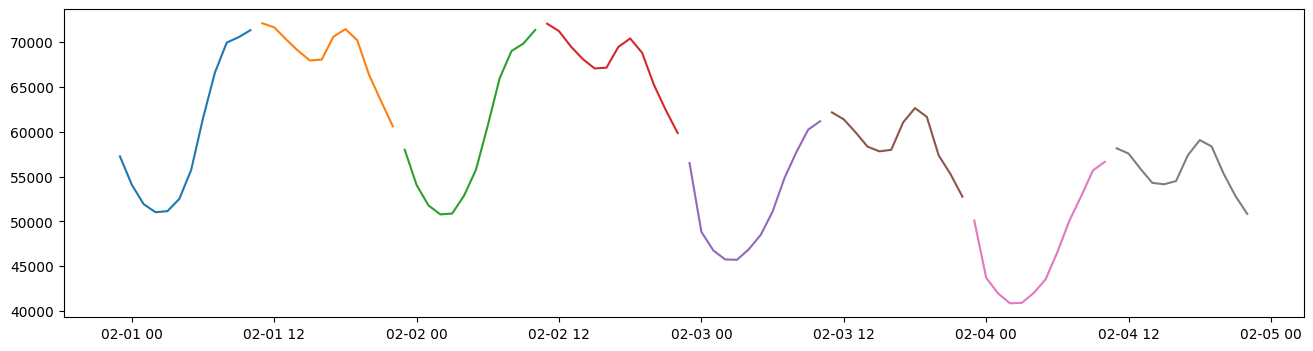

,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-01-31 22:00:00+00:00,50423.940218,55511.491513,57250.635078,58337.104114,63084.657085
2024-01-31 23:00:00+00:00,48442.903947,51739.819325,54082.236701,55258.594810,57855.854367
2024-02-01 00:00:00+00:00,46262.855162,50025.693516,51913.276009,53116.797683,55697.987780
2024-02-01 01:00:00+00:00,45538.826085,48625.048989,51017.402441,51870.006724,54841.670756
2024-02-01 02:00:00+00:00,45839.703522,49033.747794,51132.928000,51860.777913,54381.336472
...,...,...,...,...,...
2024-02-04 17:00:00+00:00,53010.588755,57223.499449,59073.780722,61143.959627,63766.666560
2024-02-04 18:00:00+00:00,52309.746535,56747.996204,58362.370113,60710.311697,62697.501562
2024-02-04 19:00:00+00:00,49811.627750,52929.580077,55351.708551,56922.072997,59056.617687
2024-02-04 20:00:00+00:00,47371.285569,51370.930272,52840.979636,54748.580351,56818.477412


In [87]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset to create future features for fcast
end = df_energy.index.max()
start = df_energy.index.max() - pd.Timedelta(days=7)
print(f"first input dataframe from {start} to {end}")

# this dataframe has values of past 7 days = last week
# because in the first step we predict the next 12 hours
# and we need the lagged values of last week for grad boost features
df_energy_small = df_energy.loc[(df_energy.index > start) & (df_energy.index <= end)]

df_fcast_iter_all = pd.DataFrame()
iterations = 8
iteration_length = 12
# fig, axes = plt.subplots(1, iterations, figsize=(iterations*8,4))
# axes = axes.flatten()
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

print("- " * 15)
print(f"> to be forecasted")

for fcast_iter in range(iterations):
    if fcast_iter > 0:
        df_energy_small = pd.concat((df_energy_small, df_ens_fcast_loop))
        end = df_energy_small.index.max()
        # print(f"new end timestamp: {end}")

    # add fcast index for next 12 hours
    fcast_timestamp_UTC = pd.date_range(
        start=end, periods=iteration_length + 1, freq="H"
    )[1:]
    fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert("CET")

    print(f"{fcast_timestamp_UTC.min()} to {fcast_timestamp_UTC.max()}", end="\r")

    # create df with timestamps of next 12 hours
    df_temp = pd.DataFrame(index=fcast_timestamp_UTC)
    df_temp["timestamp_CET"] = fcast_timestamp_CET

    # add to dataframe as new rows with NaN values in gesamt column
    df_fcast = pd.concat((df_energy_small, df_temp))

    # use data from last week for features
    # take only the last 12 rows
    df_fcast_fturs = data_prepro.create_features_df(
        df_fcast, holiday_method="separate", lags=[24, 7 * 24]
    ).tail(iteration_length)
    df_fcast_dummy = data_prepro.create_dummy_df(
        df_fcast, hour_method="seasonal", holiday_method="separate"
    ).tail(iteration_length)

    # print(df_fcast_dummy.index)
    # print(df_fcast_fturs.index)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
    # fcast

    # save fcast in df with columns = quantiles
    df_quant_reg_fcast = pd.DataFrame(index=df_fcast_dummy.index)
    df_grad_boost_fcast = pd.DataFrame(index=df_fcast_fturs.index)

    # Prediction for Quantile Regression
    for name, quant_reg_model in sorted(all_models_quant_reg.items()):
        pred = quant_reg_model.predict(
            df_fcast_dummy.drop(["gesamt", "timestamp_CET"], axis=1)
        )
        df_quant_reg_fcast[name] = pred

    # Prediction for Gradient Boosting
    for name, grad_boost_model in sorted(all_models_grad_boost.items()):
        pred = grad_boost_model.predict(
            df_fcast_fturs.drop(["gesamt", "timestamp_CET"], axis=1)
        )
        df_grad_boost_fcast[name] = pred

    # take ensemble of q 0.500 of both models
    ens_fcast = (
        df_quant_reg_fcast["q 0.500"].values + df_grad_boost_fcast["q 0.500"].values
    ) / 2
    df_ens_fcast_loop = pd.DataFrame(index=df_quant_reg_fcast.index)
    df_ens_fcast_loop["timestamp_CET"] = df_ens_fcast_loop.index.tz_convert("CET")
    df_ens_fcast_loop["gesamt"] = ens_fcast
    df_ens_fcast_loop

    # plt.figure(figsize=(8,2))
    # ax = axes[fcast_iter]
    ax.plot(df_ens_fcast_loop["timestamp_CET"], ens_fcast)

    # save fcast to df
    df_ens_fcast_out = df_quant_reg_fcast * 0.5 + df_grad_boost_fcast * 0.5
    df_ens_fcast_out = df_ens_fcast_out.groupby(df_ens_fcast_out.index).mean()
    df_fcast_iter_all = pd.concat((df_fcast_iter_all, df_ens_fcast_out))

print("")
print("= " * 15)
print(f"all iterative fcasts done ...")

plt.show()
display(df_fcast_iter_all)

#### Fix QC & Save to csv

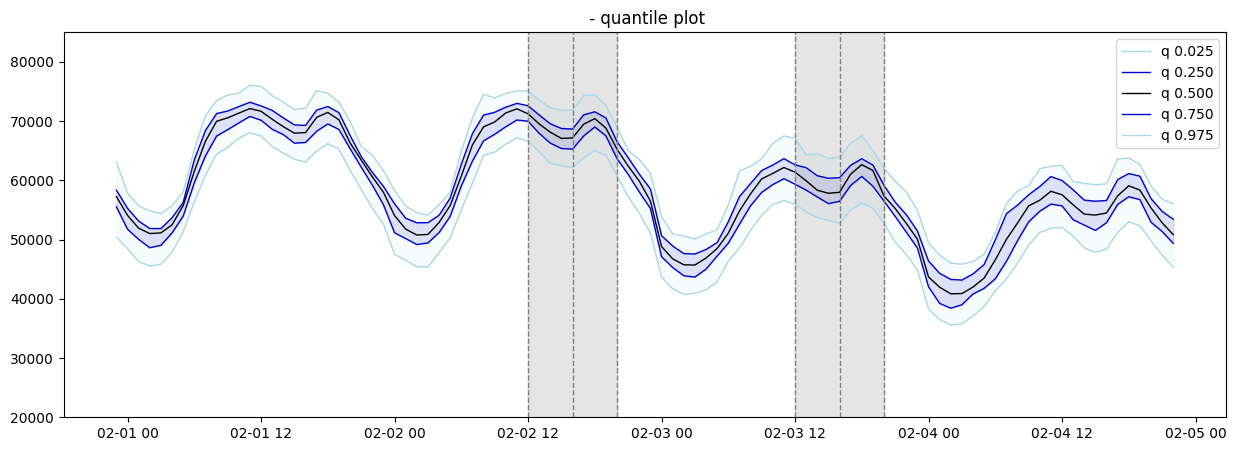

In [88]:
# - - - - - - - - - - - - -
# fix quantile crossing
df_iter_fcast_all_fixed = data_prepro.fix_quantile_crossing(df_fcast_iter_all)
# current fcast index is based on UTC only, add CET col
df_iter_fcast_all_fixed["timestamp_CET"] = df_iter_fcast_all_fixed.index.tz_convert(
    "CET"
)
# reorder cols
df_iter_fcast_all_fixed = df_iter_fcast_all_fixed[
    ["timestamp_CET", "q 0.025", "q 0.250", "q 0.500", "q 0.750", "q 0.975"]
]

# - - - - - - - - - - - - -
# plot + highlight submission horizons
model_train.plot_quantile_fcast(df_iter_fcast_all_fixed, subm_timestamps)

# - - - - - - - - - - - - -
# get fcast values for required submission horizons
mask = df_iter_fcast_all_fixed["timestamp_CET"].isin(subm_timestamps)
# shift mask by 1
mask = mask.shift(-1).fillna(False)
df_submission = df_iter_fcast_all_fixed.loc[mask, :]
# display(df_submission)

# - - - - - - - - - - - - -
# turn to array and div by 1000
submission_arr = np.array(df_submission.iloc[:, 1:] / 1000)

df_sub = pd.DataFrame(
    {
        "forecast_date": t_wednesday.strftime("%Y-%m-%d"),
        "target": "energy",
        "horizon": [str(h) + " hour" for h in fcast_hor],
        "q0.025": submission_arr[:, 0],
        "q0.25": submission_arr[:, 1],
        "q0.5": submission_arr[:, 2],
        "q0.75": submission_arr[:, 3],
        "q0.975": submission_arr[:, 4],
    }
)

# - - - - - - - - - - - - -
# if folder with name {current wednesday} does not exists in 2023_11-PTSFC/submissions/... create it
# if folder exists ... save csv to it

# fname_time = t_wednesday.strftime('%Y_%m_%d')
# path = f"C:/2023_11-PTSFC/submissions/{fname_time}"
# if not os.path.exists(path):
#     os.makedirs(path)

# # save entire iterative fcast to csv
# df_iter_fcast_all_fixed.to_csv(f"{path}/{fname_time}_power_iterative_fcast.csv", index=False)

# # save submission fcast to csv
# df_sub.to_csv(f"{path}/{fname_time}_power_fcast_submission.csv", index=False)
# display(df_sub)

### Direct h-step Quant Reg Fcast

In [89]:
# create fcast index for next 96 hours
end = df_energy.index.max()
fcast_timestamp_UTC = pd.date_range(start=end, periods=96 + 1, freq="H")[1:]
fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert("CET")

print("- " * 15)
print(f"> to be forecasted")
print(f"{fcast_timestamp_UTC.min()} to {fcast_timestamp_UTC.max()}")

# create df with fcast timestamps
df_temp = pd.DataFrame(index=fcast_timestamp_UTC)
df_temp["timestamp_CET"] = fcast_timestamp_CET
df_fcast_dummy = data_prepro.create_dummy_df(
    df_temp, hour_method="seasonal", holiday_method="separate"
)
# display(df_fcast_dummy)
# display(df_fcast_dummy.tail())

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# fcast

print("- " * 15)
print(f"> start prediction ...")

# save fcast in df with columns = quantiles
df_quant_reg_direct_fcast = pd.DataFrame(index=df_fcast_dummy.index)

# Prediction for Quantile Regression
for name, quant_reg_model in sorted(all_models_quant_reg.items()):
    pred = quant_reg_model.predict(df_fcast_dummy.drop("timestamp_CET", axis=1))
    df_quant_reg_direct_fcast[name] = pred

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-31 22:00:00+00:00 to 2024-02-04 21:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


#### Fix QC and Save

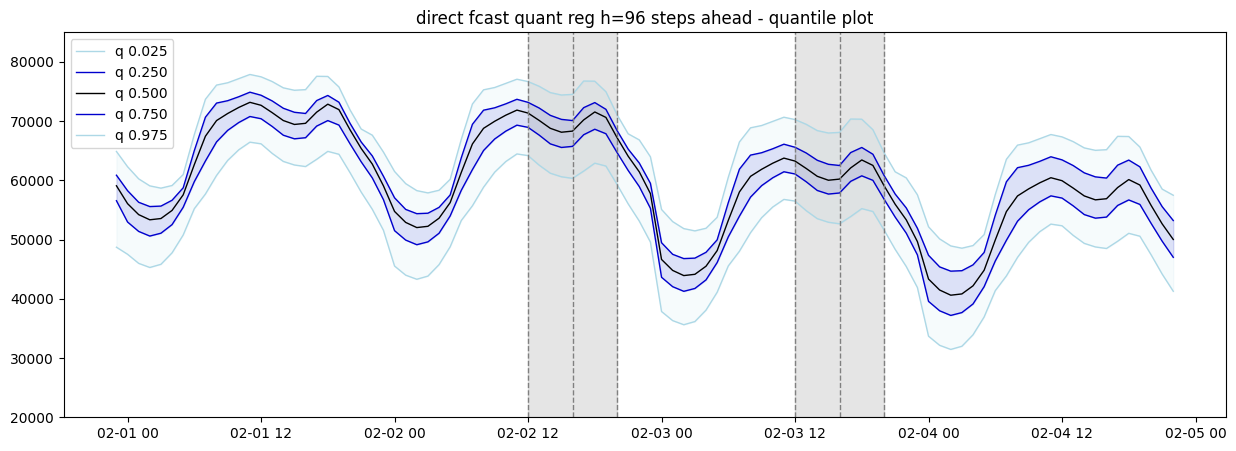

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-31,energy,36 hour,64.4580,69.319167,71.861000,73.68825,77.074679
1,2024-01-31,energy,40 hour,60.6025,65.554917,68.125000,70.29525,74.406750
2,2024-01-31,energy,44 hour,62.4140,67.872458,70.626250,71.99175,74.965357
3,2024-01-31,energy,60 hour,56.7825,61.450437,63.756125,66.10500,70.660107
4,2024-01-31,energy,64 hour,52.9270,57.686188,60.020125,62.71200,67.992179
5,2024-01-31,energy,68 hour,54.7385,60.003729,62.521375,64.40850,68.550786


In [90]:
# - - - - - - - - - - - - -
# add CET col
df_quant_reg_direct_fcast["timestamp_CET"] = df_quant_reg_direct_fcast.index.tz_convert(
    "CET"
)
# reorder cols
df_quant_reg_direct_fcast = df_quant_reg_direct_fcast[
    ["timestamp_CET", "q 0.025", "q 0.250", "q 0.500", "q 0.750", "q 0.975"]
]

# - - - - - - - - - - - - -
# plot + highlight submission horizons
model_train.plot_quantile_fcast(
    df_quant_reg_direct_fcast,
    subm_timestamps,
    title="direct fcast quant reg h=96 steps ahead",
)

# - - - - - - - - - - - - -
# get fcast values for required submission horizons
mask = df_quant_reg_direct_fcast["timestamp_CET"].isin(subm_timestamps)
# shift mask by 1
mask = mask.shift(-1).fillna(False)
df_submission = df_quant_reg_direct_fcast.loc[mask, :]
# display(df_submission)

# - - - - - - - - - - - - -
# turn to array and div by 1000
submission_arr = np.array(df_submission.iloc[:, 1:] / 1000)

df_sub = pd.DataFrame(
    {
        "forecast_date": t_wednesday.strftime("%Y-%m-%d"),
        "target": "energy",
        "horizon": [str(h) + " hour" for h in fcast_hor],
        "q0.025": submission_arr[:, 0],
        "q0.25": submission_arr[:, 1],
        "q0.5": submission_arr[:, 2],
        "q0.75": submission_arr[:, 3],
        "q0.975": submission_arr[:, 4],
    }
)

display(df_sub)

### Naive Benchmark

In [91]:
# - - - - - - - - - - - - -
# create fcast index for next 96 hours
end = df_energy.index.max()
fcast_timestamp_UTC = pd.date_range(start=end, periods=96 + 1, freq="H")[1:]
fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert("CET")

fcast_timestamps = fcast_timestamp_CET
# fcast_timestamps = subm_timestamps

# - - - - - - - - - - - - -
df_energy_benchmark = df_energy.copy()
df_energy_benchmark["month"] = df_energy_benchmark["timestamp_CET"].dt.month
df_energy_benchmark["weekday"] = df_energy_benchmark[
    "timestamp_CET"
].dt.weekday  # Monday=0, Sunday=6
df_energy_benchmark["weeknum"] = (
    df_energy_benchmark["timestamp_CET"].dt.isocalendar().week
)

last_t = 100
methods = ["linear", "median_unbiased", "normal_unbiased", "weibull"]

number_of_matches_in_past = 0
pred_baseline = np.zeros((len(methods), len(fcast_timestamps), 5))

for i, d in enumerate(fcast_timestamps):
    weekday = d.weekday()
    hour = d.hour
    weeknum = d.week

    # condition that the weekday and hour match AND the weeknum is within +/- 2 weeks of the target
    # cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark['weeknum'].between(weeknum-2, weeknum+2))

    # alternatively:
    # condition that the weekday and hour match AND the month also matches
    # cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark.index.month == d.month)

    # alternatively:
    # condition that the weekday and hour match AND the month is within +/- 1 months of the target
    cond = (
        (df_energy_benchmark.weekday == weekday)
        & (df_energy_benchmark.index.time == d.time())
        & (df_energy_benchmark["month"].between(d.month - 1, d.month + 1))
    )

    match_df = df_energy_benchmark[cond]
    number_of_matches_in_past += match_df.shape[0]

    for m_idx, method in enumerate(methods):
        pred_baseline[m_idx, i, :] = np.quantile(
            match_df.iloc[-last_t:]["gesamt"], q=quantiles, method=method
        )

number_of_matches_in_past = number_of_matches_in_past / len(fcast_timestamps)
print(f"avg number_of_matches_in_past = {number_of_matches_in_past:.2f}")

dict_benchmark_fcast = {}

for m_idx, method in enumerate(methods):
    print("- " * 15)
    print(f"method = {method}")
    print("- " * 15)

    df_benchmark = pd.DataFrame(
        index=fcast_timestamps, columns=[f"q {q:.3f}" for q in quantiles]
    )
    df_benchmark.loc[:, :] = pred_baseline[m_idx, :, :]
    # - - - - - - - - - - - - -
    # make sure all cols are float
    df_benchmark = df_benchmark.astype(float)
    # - - - - - - - - - - - - -
    # add CET col
    df_benchmark["timestamp_CET"] = df_benchmark.index.tz_convert("CET")
    # reorder cols
    df_benchmark = df_benchmark[
        ["timestamp_CET", "q 0.025", "q 0.250", "q 0.500", "q 0.750", "q 0.975"]
    ]
    # - - - - - - - - - - - - -
    # display(df_benchmark)

    dict_benchmark_fcast[method] = df_benchmark

avg number_of_matches_in_past = 119.24
- - - - - - - - - - - - - - - 
method = linear
- - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - 
method = median_unbiased
- - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - 
method = normal_unbiased
- - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - 
method = weibull
- - - - - - - - - - - - - - - 


#### Plot Naive Benchmark

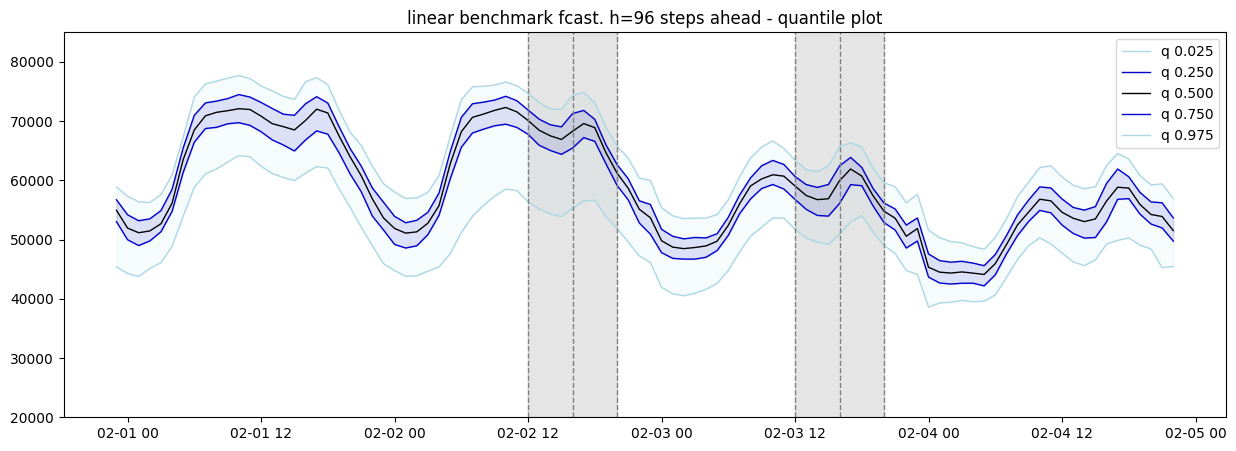

In [92]:
# for method in methods:
#     model_train.plot_quantile_fcast(dict_benchmark_fcast[method], subm_timestamps, title=f'{method} benchmark fcast. h=96 steps ahead')

method = "linear"
model_train.plot_quantile_fcast(
    dict_benchmark_fcast[method],
    subm_timestamps,
    title=f"{method} benchmark fcast. h=96 steps ahead",
)

In [93]:
# # compare the q 0.975 quantile of all benchmarks
# plt.figure(figsize=(15,5))
# for method in methods:
#     plt.plot(dict_benchmark_fcast[method]['timestamp_CET'], dict_benchmark_fcast[method]['q 0.975'], label=method)
# plt.legend()
# plt.show()

### Direct h-step Grad Boost Fcast using Naive Benchmark / Direct Quant Reg

In [94]:
# [TODO]

### Combine Ensemble = Direct QR + Direct GB + Benchmark

In [95]:
# [TODO]

### MSTL Fcast

In [96]:
from statsforecast.models import MSTL

mstl_train_horizon = 0.5

df_mstl_train = df_energy.iloc[-int(mstl_train_horizon * 365 * 24) :].copy()
mstl_model = MSTL(season_length=[24, 24 * 7]).fit(df_mstl_train["gesamt"])

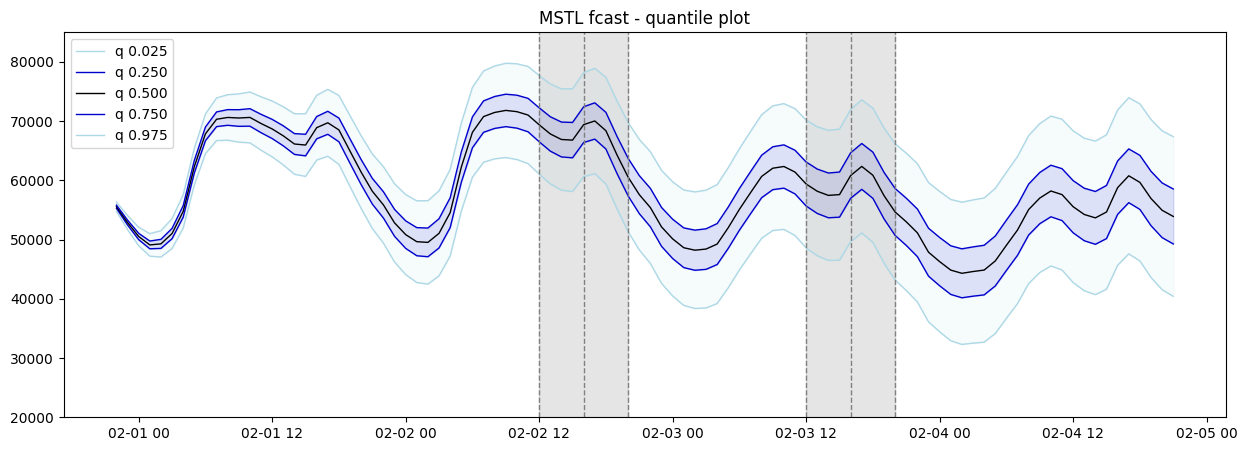

In [99]:
n_steps = 96

y_hat_dict = mstl_model.predict(h=n_steps, level=[50, 95])
y_hat_df = pd.DataFrame(y_hat_dict)
y_hat_df["timestamp_CET"] = pd.date_range(
    start=df_mstl_train["timestamp_CET"].max(), periods=len(y_hat_df), freq="H"
)

# rename columns
y_hat_df = y_hat_df.rename(
    columns={
        "mean": "q 0.500",
        "lo-50": "q 0.250",
        "hi-50": "q 0.750",
        "lo-95": "q 0.025",
        "hi-95": "q 0.975",
    }
)

y_hat_df = y_hat_df[
    ["timestamp_CET", "q 0.025", "q 0.250", "q 0.500", "q 0.750", "q 0.975"]
]
model_train.plot_quantile_fcast(y_hat_df, subm_timestamps, title="MSTL fcast")

df_mstl_fcast = y_hat_df.copy()
df_mstl_fcast.index = dict_benchmark_fcast['linear'].index

### Save csv

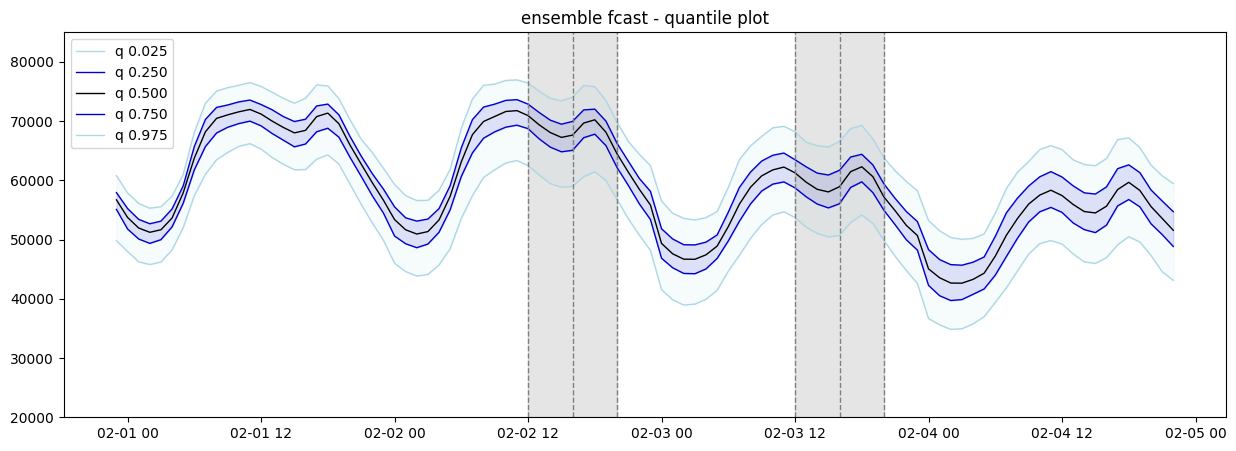

In [101]:
# average of all 3 fcasts with custom weighting
w_iter = 0.25
w_direct = 0.25
w_bench = 0.25
w_mstl = 0.25
                                             
# but ignore the first column "timestamp_CET" when calculating the average
df_ens_fcast = (df_iter_fcast_all_fixed.iloc[:,1:] * w_iter + 
                df_quant_reg_direct_fcast.iloc[:,1:] * w_direct + 
                dict_benchmark_fcast['linear'].iloc[:,1:] * w_bench + 
                df_mstl_fcast.iloc[:,1:] * w_mstl)

df_ens_fcast['timestamp_CET'] = df_iter_fcast_all_fixed['timestamp_CET']
# move timestamp col to first position
cols = df_ens_fcast.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_ens_fcast = df_ens_fcast[cols]
        
# plot
model_train.plot_quantile_fcast(df_ens_fcast, subm_timestamps, title='ensemble fcast')

In [102]:
# - - - - - - - - - - - - - 
# get fcast values for required submission horizons
mask = df_ens_fcast['timestamp_CET'].isin(subm_timestamps) 

df_submission = df_ens_fcast.loc[mask,:]
display(df_submission)

# - - - - - - - - - - - - - 
# turn to array and div by 1000
submission_arr = np.array(df_submission.iloc[:,1:]/1000)

df_sub = pd.DataFrame({
    
    "forecast_date": t_wednesday.strftime("%Y-%m-%d"), 
    "target": "energy",
    "horizon": [str(h) + " hour" for h in fcast_hor],
    "q0.025": submission_arr[:,0],
    "q0.25": submission_arr[:,1],
    "q0.5": submission_arr[:,2],
    "q0.75": submission_arr[:,3],
    "q0.975": submission_arr[:,4]

})

# - - - - - - - - - - - - - 
# if folder with name {current wednesday} does not exists in 2023_11-PTSFC/submissions/... create it
# if folder exists ... save csv to it

fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"./submissions/{fname_time}"
if not os.path.exists(path):
    os.makedirs(path)
    
# save submission fcast to csv
df_sub.to_csv(f"{path}/{fname_time}_power_fcast_submission.csv", index=False)
display(df_sub)

,timestamp_CET,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-02-02 11:00:00+00:00,2024-02-02 12:00:00+01:00,62498.392888,68729.764223,70933.161350,72872.830341,76427.594545
2024-02-02 15:00:00+00:00,2024-02-02 16:00:00+01:00,58984.019289,65068.777497,67636.890559,69950.288947,74059.117986
2024-02-02 19:00:00+00:00,2024-02-02 20:00:00+01:00,56763.451968,62162.090963,64491.224762,66256.695965,69808.170601
2024-02-03 11:00:00+00:00,2024-02-03 12:00:00+01:00,53726.462955,58727.096653,61271.472510,63485.264769,68210.214885
2024-02-03 15:00:00+00:00,2024-02-03 16:00:00+01:00,50709.871356,56054.313504,58931.806722,61703.658079,66585.265850
2024-02-03 19:00:00+00:00,2024-02-03 20:00:00+01:00,49830.060023,54922.055883,57168.159413,59380.327048,63770.141835


,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-31,energy,36 hour,62.498393,68.729764,70.933161,72.872830,76.427595
1,2024-01-31,energy,40 hour,58.984019,65.068777,67.636891,69.950289,74.059118
2,2024-01-31,energy,44 hour,56.763452,62.162091,64.491225,66.256696,69.808171
3,2024-01-31,energy,60 hour,53.726463,58.727097,61.271473,63.485265,68.210215
4,2024-01-31,energy,64 hour,50.709871,56.054314,58.931807,61.703658,66.585266
5,2024-01-31,energy,68 hour,49.830060,54.922056,57.168159,59.380327,63.770142


### Get Actual Data

In [ ]:
""" 
now since we ran the model in retrospect on a past week 
we can compare the fcast with the actual values and compute quantile scores etc

"""

# = = = = = = = = = = = = =
# import actual data

# # get days left till sunday
# days_left = 6 - t_now.dayofweek
# # get next saturday of week in t_now
# t_sunday = t_now + pd.Timedelta(days=days_left)
# print(f"sun = {t_sunday}")

# just get next thursday
t_wednesday_next = t_wednesday + pd.Timedelta(days=7)
print(f"next thu = {t_wednesday_next}")

# = = = = = = = = = = = = =
# get data
df_energy_new = data_prepro.get_energy_data_today(
    to_date=t_wednesday_next.strftime("%Y%m%d")
)
df_energy_new.info()
df_energy_new.tail(5)

### Evaluation

In [ ]:
# we have 4 fcasts
df_benchmark_fcast = dict_benchmark_fcast["linear"]
df_mstl_fcast = y_hat_df
df_mstl_fcast.index = df_benchmark_fcast.index

all_model_names = ["iterative", "direct", "benchmark", "mstl"]
all_models_dict = {
    "iterative": df_iter_fcast_all_fixed,
    "direct": df_quant_reg_direct_fcast,
    "benchmark": df_benchmark_fcast,
    "mstl": df_mstl_fcast,
}
# make all possible ensemble combinations between 1, 2, 3 and 4 models
import itertools

combis4 = list(itertools.combinations(all_model_names, 4))
combis3 = list(itertools.combinations(all_model_names, 3))
combis2 = list(itertools.combinations(all_model_names, 2))
combis_all = combis4 + combis3 + combis2 + [(model,) for model in all_model_names]

scores_dict = {}

for combi in combis_all:
    # take first model
    df_ens_fcast = all_models_dict[combi[0]].copy()

    # take all other models and add their q 0.500 to the first model
    for model in combi[1:]:
        df_ens_fcast.iloc[:, 1:] += all_models_dict[model].iloc[:, 1:]

    # divide by number of models
    df_ens_fcast.iloc[:, 1:] = df_ens_fcast.iloc[:, 1:] / len(combi)

    combi_name = "_".join(combi)
    scores_dict[combi_name] = model_eval.eval_fcast(df_ens_fcast, df_energy_new, subm_timestamps, quantiles).iloc[-1:]

# make dataframe from dictionary
df_res = pd.concat(scores_dict.values())
df_res.index = scores_dict.keys()

# add col of avg q scores
df_res["avg_q"] = df_res[
    [
        "q-score 0.025",
        "q-score 0.250",
        "q-score 0.500",
        "q-score 0.750",
        "q-score 0.975",
    ]
].mean(axis=1)

# rank by avg q score
df_res = df_res.sort_values(by="avg_q")
display(df_res.head(20))

,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975,avg_q
iterative,1262.752257,0.318512,0.858148,1.262752,0.884385,0.210017,0.706763
iterative_direct,1216.019226,0.410682,1.001906,1.216019,1.087192,0.261097,0.795379
iterative_direct_benchmark,1374.403530,0.437459,1.288538,1.374404,0.962931,0.215124,0.855691
iterative_direct_mstl,1607.800019,0.368122,1.172088,1.607800,1.080469,0.267688,0.899233
iterative_direct_benchmark_mstl,1495.427164,0.398845,1.389371,1.495427,1.129915,0.231560,0.929024
direct,1485.854167,0.502852,1.145665,1.485854,1.290000,0.312177,0.947310
iterative_benchmark,1622.027647,0.404762,1.395138,1.622028,1.173022,0.166598,0.952310
iterative_mstl,1803.481278,0.300757,1.220463,1.803481,1.215156,0.245443,0.957060
direct_benchmark,1493.166667,0.496932,1.558279,1.493167,1.044674,0.217678,0.962146
iterative_benchmark_mstl,1639.257052,0.364175,1.494048,1.639257,1.325637,0.204688,1.005561
